In [49]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/processed/yp_competitors_rws_0001_0050_topics.csv')
df.head()

,lsi_topic_mode,lsi_topic_mode_prob,lsi_topic_list,lda_topic_mode,lda_topic_mode_prob,lda_topic_list,mallet_topic_mode,mallet_topic_mode_prob,mallet_topic_list
0,0,"0,0,0,0,0,0,0,0,1,0,0","[(0, 0.5883372663129702), (0, 0.18895234778185...",4,"3,4,0,2,4,2,1,1,0,4,0","[(3, 0.66899663), (4, 0.50371903), (0, 0.64461...",5,"4,7,0,8,6,5,2,8,5,5,0","[(4, 0.13793103448275862), (7, 0.1388888888888..."
1,0,"4,1,0,0,0","[(4, 0.47860746761404704), (1, 0.4255610631060...",1,"1,0,2,1,1","[(1, 0.32851106), (0, 0.7329292), (2, 0.866291...",1,"9,1,0,3,1","[(9, 0.13991769547325106), (1, 0.1196581196581..."
2,0,"0,0,4,3,4,1,0,0,0,0,0,0,0,2","[(0, 0.1348959318450177), (0, 0.11324654379260...",3,"3,0,1,1,1,2,3,3,2,2,0,3,3,4","[(3, 0.79906136), (0, 0.39259952), (1, 0.76395...",2,"2,9,9,2,9,8,1,2,1,8,8,7,4,1","[(2, 0.13207547169811323), (9, 0.1551724137931..."
3,0,"0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,...","[(0, 0.6560500501677016), (0, 0.02440018163349...",0,"2,3,3,2,1,0,3,3,0,4,0,1,0,0,1,0,2,0,3,2,2,4,4,...","[(2, 0.71843004), (3, 0.5987209), (3, 0.651143...",3,"4,3,2,1,1,6,2,1,1,9,2,2,3,3,3,0,4,6,4,3,3,3,3,...","[(4, 0.17962962962962964), (3, 0.1176470588235..."
4,0,"0,3,1,3,3,0,1,0,0,1","[(0, 0.11595256140451615), (3, 0.5082008134524...",2,"3,0,2,4,2,1,4,0,2,3","[(3, 0.5947283), (0, 0.5634973), (2, 0.3487434...",1,"1,2,8,3,9,9,1,1,3,1","[(1, 0.13207547169811323), (2, 0.1132075471698..."


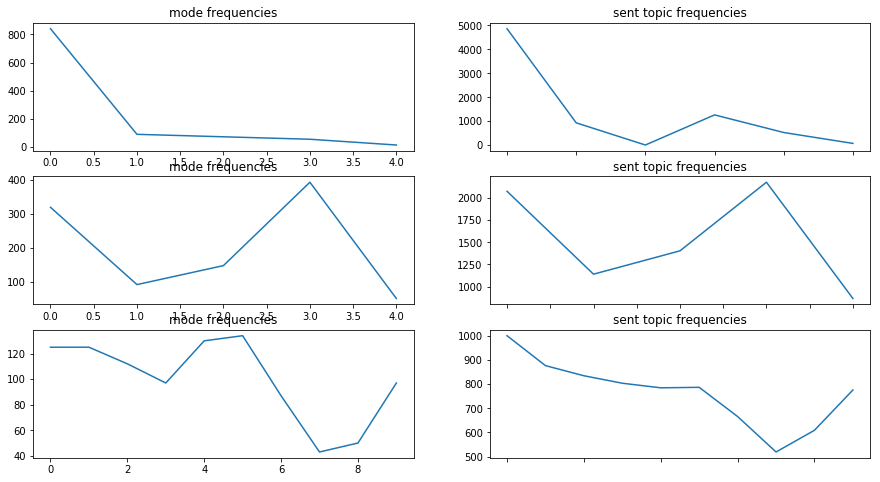

In [51]:
# all topics frequency distribution 
import matplotlib.pyplot as plt

topic_models_list = ['lsi_topic_mode', 'lda_topic_mode', 'mallet_topic_mode']
fig, axes = plt.subplots(3, 2, figsize=(15, 8))

for i, model in enumerate(topic_models_list):
    topic_freqs = df[model].value_counts().sort_index().plot(ax=axes[i, 0], title='mode frequencies')
    pd_topic_frequencies = df[model+'_prob'].apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
    topic_sent_freqs = pd_topic_frequencies.sum().sort_index().plot(ax=axes[i, 1], title='sent topic frequencies')

plt.show()

In [6]:
df.lsi_topic_mode.value_counts()

0.0    17858
4.0      591
1.0      478
2.0       91
3.0        1
Name: lsi_topic_mode, dtype: int64

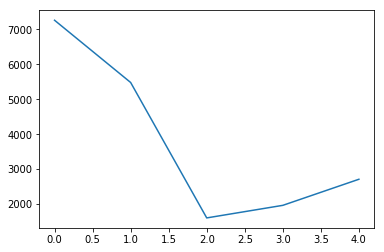

In [32]:
df.lda_topic_mode.value_counts().sort_index().plot()

In [17]:
pd_topic_frequencies = df.lda_topic_mode_prob.apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
pd_topic_frequencies.head()

,1,2,0,4,3
0,4.0,3.0,2.0,2.0,0.0
1,3.0,1.0,0.0,1.0,0.0
2,2.0,1.0,5.0,5.0,1.0
3,7.0,10.0,7.0,5.0,5.0
4,3.0,0.0,4.0,1.0,2.0


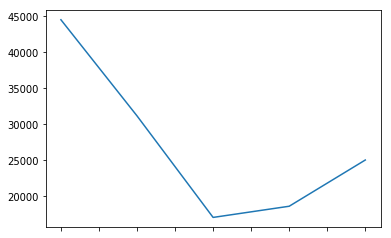

In [33]:
pd_topic_frequencies.sum().sort_index().plot()

In [67]:
from ast import literal_eval
df.lda_topic_list.apply(lambda x: literal_eval(x))

0      [(3, 0.66899663), (4, 0.50371903), (0, 0.64461...
1      [(1, 0.32851106), (0, 0.7329292), (2, 0.866291...
2      [(3, 0.79906136), (0, 0.39259952), (1, 0.76395...
3      [(2, 0.71843004), (3, 0.5987209), (3, 0.651143...
4      [(3, 0.5947283), (0, 0.5634973), (2, 0.3487434...
5      [(3, 0.86579376), (1, 0.88504833), (0, 0.37153...
6      [(3, 0.599212), (3, 0.5954598), (0, 0.8395318)...
7      [(3, 0.44484606), (3, 0.5483191), (1, 0.354427...
8      [(3, 0.9329004), (0, 0.46833846), (3, 0.592511...
9      [(0, 0.5965644), (3, 0.7444819), (0, 0.8366664...
10     [(2, 0.3692484), (2, 0.6651338), (2, 0.5978307...
11     [(3, 0.6012978), (0, 0.38507918), (3, 0.839409...
12     [(3, 0.74282974), (3, 0.9198717), (3, 0.678796...
13     [(3, 0.9266803), (3, 0.80463064), (0, 0.650083...
14     [(3, 0.8851719), (3, 0.49753532), (0, 0.708632...
15     [(3, 0.5308712), (4, 0.41583744), (2, 0.414031...
16     [(3, 0.65762854), (3, 0.53302866), (4, 0.44697...
17     [(1, 0.5354491), (0, 0.6